# Classifier for shoes, sandals and boots

## Task
Train an image classifier for footwear. 

The data set contains 3 target classes: shoe, boot & sandal. Overall the data set contains 15,000 images of size 136x102  which are evenly distributed across all three classes resulting in 5,000 images per class. The test set was manually split beforehand. The validation set however was split automatically by keras. The distribution of images across the the partitions is roughly 80/10/10.


The data set can be found here: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

In [9]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sklearn.metrics as sklm

# Constants

In [10]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32
data_dir = "C:\\Users\\olive\\Documents\\temp\\AKT\\data"
test_dir = "C:\\Users\\olive\\Documents\\temp\\AKT\\test"

# Setup training and validation data

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.11
)

train_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='training')

valid_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=batch_size, 
                                                     shuffle=False, # important otherwise .evaluate() and .predict() result in different values ....
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='validation')

print(train_data_gen.class_indices)
print(valid_data_gen.class_indices)

Found 12015 images belonging to 3 classes.
Found 1485 images belonging to 3 classes.
{'Boot': 0, 'Sandal': 1, 'Shoe': 2}
{'Boot': 0, 'Sandal': 1, 'Shoe': 2}


# Plot sample images

{0: 'Boot', 1: 'Sandal', 2: 'Shoe'}


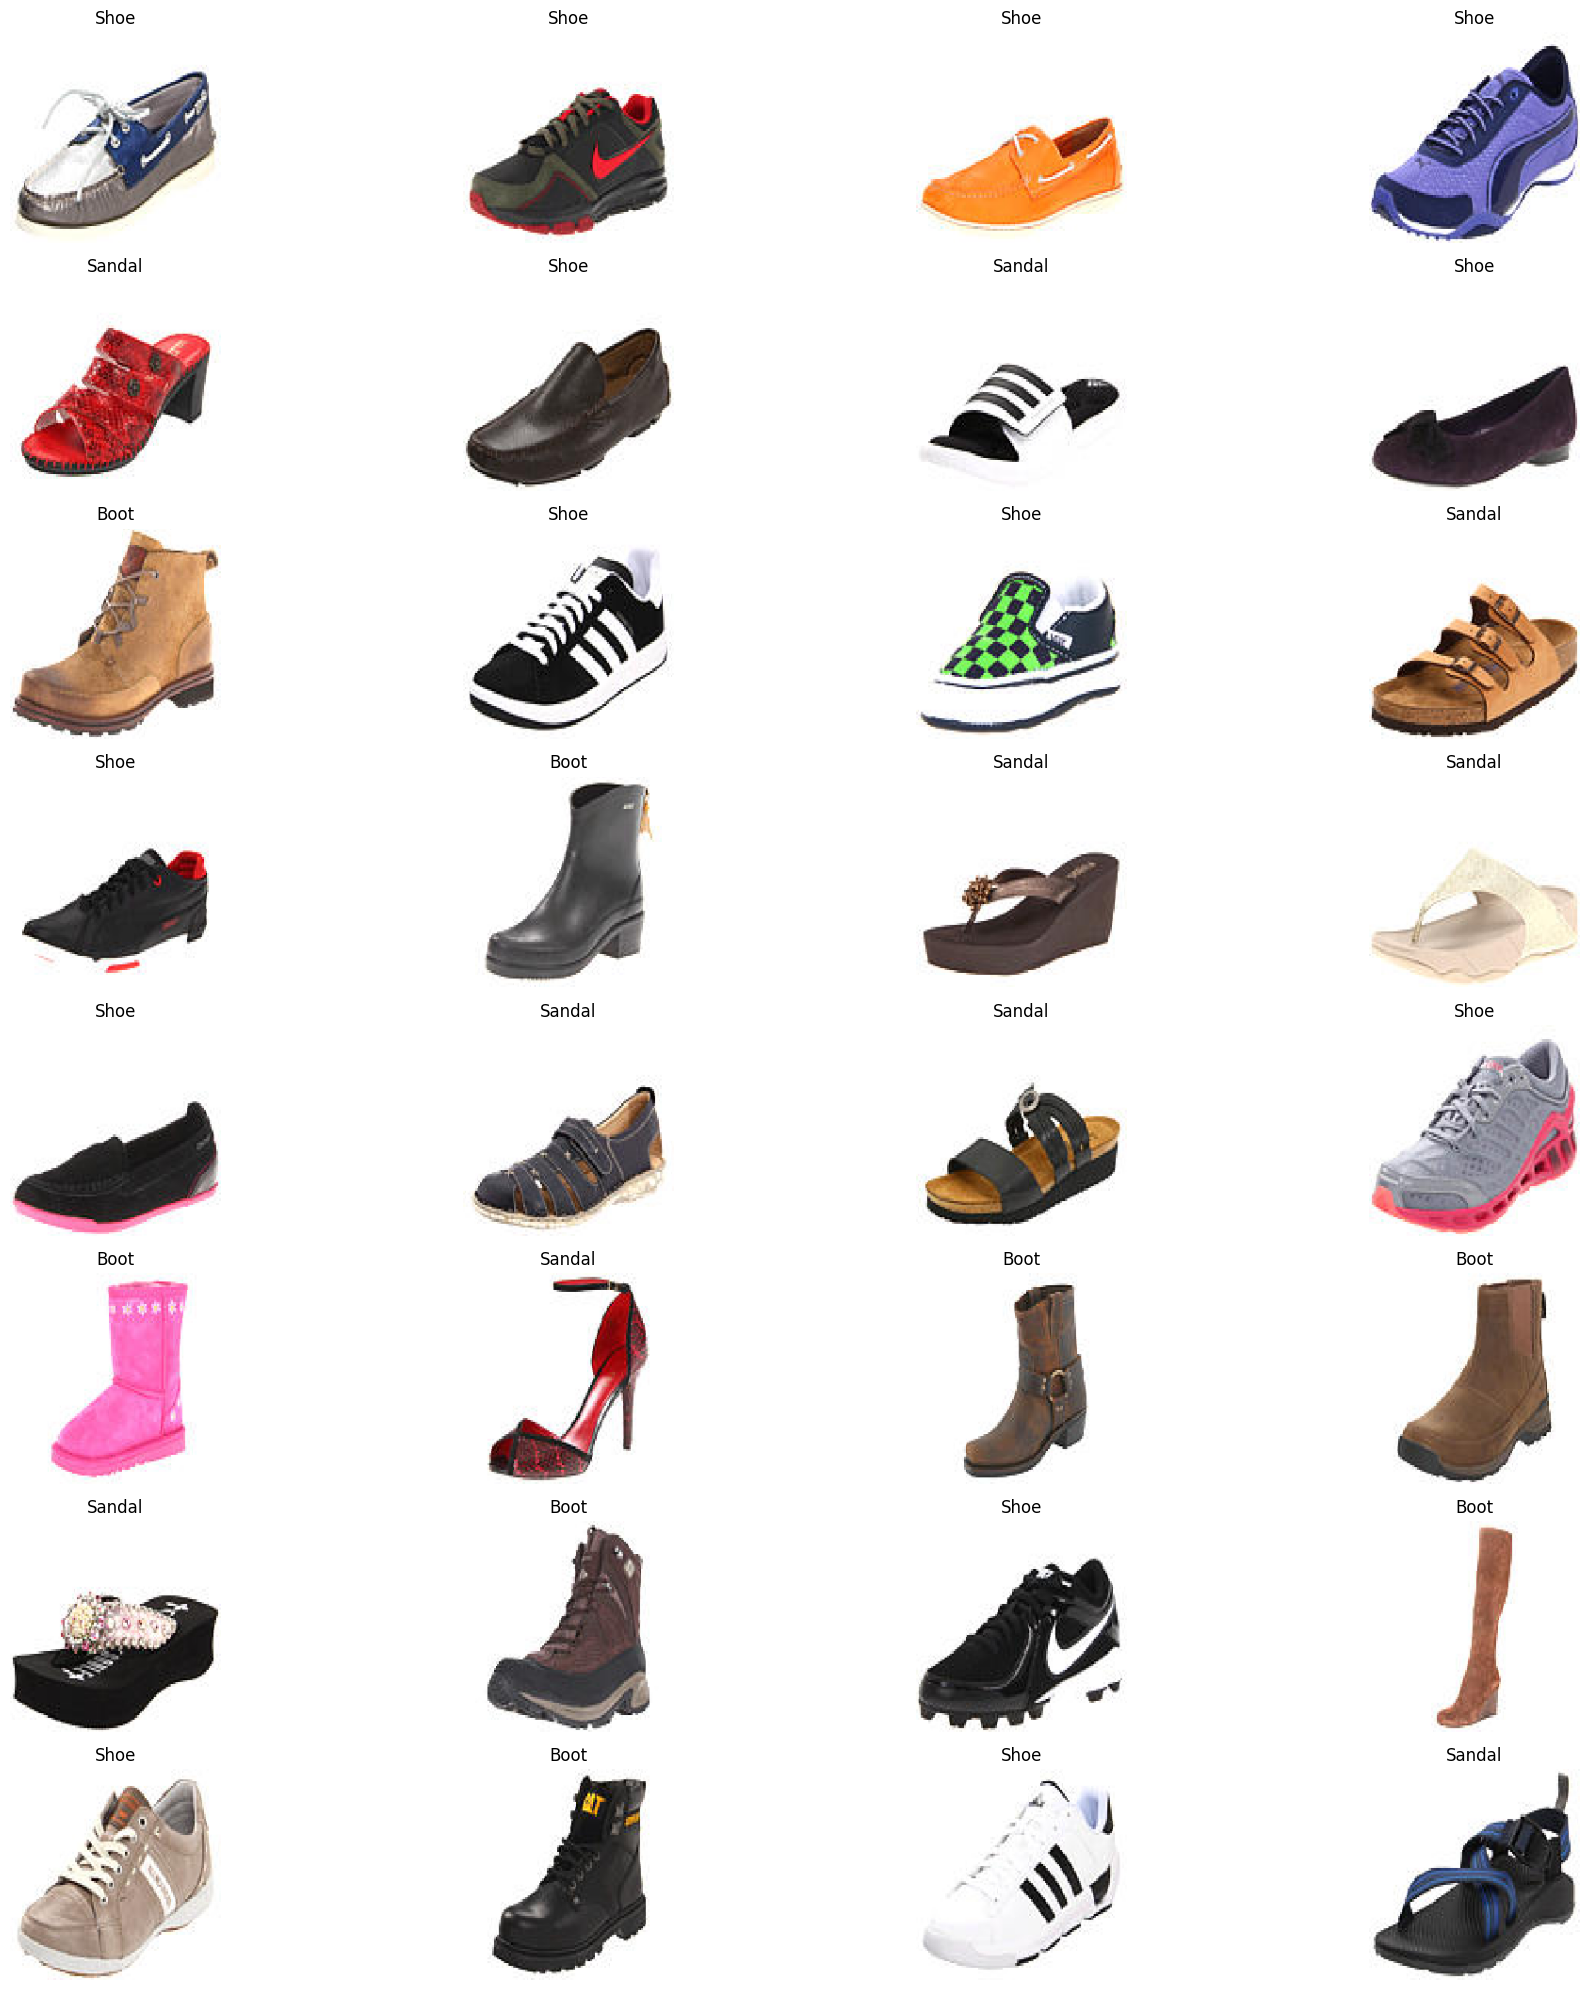

In [12]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
print(class_label)
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Setup the model

In [13]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    pooling='max',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 24,745,987
Trainable params: 1,181,187
Non-trainable params: 23,564,800
_________________________________________________________________


# Experiments with batch size

## Experiment 1: batch size halfed

In [14]:
experiment1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

experiment1_train_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                                 batch_size=batch_size // 2,
                                                                 shuffle=True,
                                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                 subset='training')

experiment1_valid_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                                 batch_size=batch_size // 2, 
                                                                 shuffle=False,
                                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                 subset='validation')

Found 12015 images belonging to 3 classes.
Found 1485 images belonging to 3 classes.


## Experiment 2: batch size = 1

In [15]:
experiment2 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

experiment2_train_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                                 batch_size=1,
                                                                 shuffle=True,
                                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                 subset='training')

experiment2_valid_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                                 batch_size=1, 
                                                                 shuffle=False,
                                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                 subset='validation')

Found 12015 images belonging to 3 classes.
Found 1485 images belonging to 3 classes.


# Train the model & experiments

In [16]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

history = model.fit(
        train_data_gen,
        validation_data = valid_data_gen,
        epochs = 5,
        steps_per_epoch=train_data_gen.samples / batch_size,
        #steps_per_epoch = 2,
        validation_steps = valid_data_gen.samples / batch_size,
        #validation_steps = 1,
    )

experiment1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

experiment1_history = experiment1.fit(
        experiment1_train_data_gen,
        validation_data = experiment1_valid_data_gen,
        epochs = 5,
        steps_per_epoch=train_data_gen.samples / (batch_size // 2),
        #steps_per_epoch = 2,
        validation_steps = valid_data_gen.samples / (batch_size // 2),
        #validation_steps = 1,
    )

experiment2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

experiment2_history = experiment2.fit(
        experiment2_train_data_gen,
        validation_data = experiment2_valid_data_gen,
        epochs = 5,
        steps_per_epoch=train_data_gen.samples,
        #steps_per_epoch = 2,
        validation_steps = valid_data_gen.samples,
        #validation_steps = 1,
    )

Epoch 1/5
375/375 [==============================] - 522s 1s/step - loss: 0.3294 - categorical_accuracy: 0.9363 - val_loss: 0.0907 - val_categorical_accuracy: 0.9704
Epoch 2/5
375/375 [==============================] - 523s 1s/step - loss: 0.0886 - categorical_accuracy: 0.9702 - val_loss: 0.0833 - val_categorical_accuracy: 0.9731
Epoch 3/5
375/375 [==============================] - 524s 1s/step - loss: 0.0589 - categorical_accuracy: 0.9794 - val_loss: 0.1063 - val_categorical_accuracy: 0.9684
Epoch 4/5
375/375 [==============================] - 523s 1s/step - loss: 0.0496 - categorical_accuracy: 0.9844 - val_loss: 0.1184 - val_categorical_accuracy: 0.9589
Epoch 5/5
375/375 [==============================] - 523s 1s/step - loss: 0.0284 - categorical_accuracy: 0.9901 - val_loss: 0.1197 - val_categorical_accuracy: 0.9643
Epoch 1/5
750/750 [==============================] - 534s 708ms/step - loss: 0.3262 - categorical_accuracy: 0.9358 - val_loss: 0.0734 - val_categorical_accuracy: 0.9751
E

# Plot training process

## Model

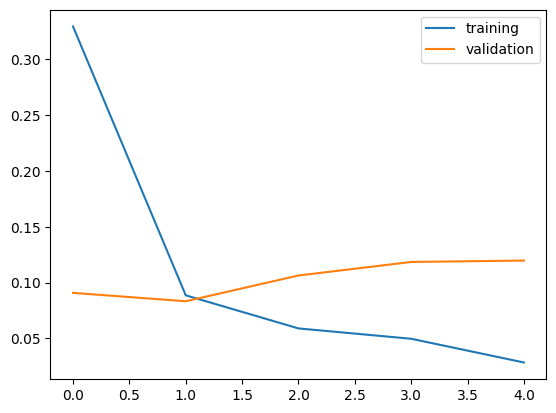

In [17]:
plt.plot(history.history['loss'], label = "training")
plt.plot(history.history['val_loss'], label = "validation")
plt.legend()

## Experiment 1

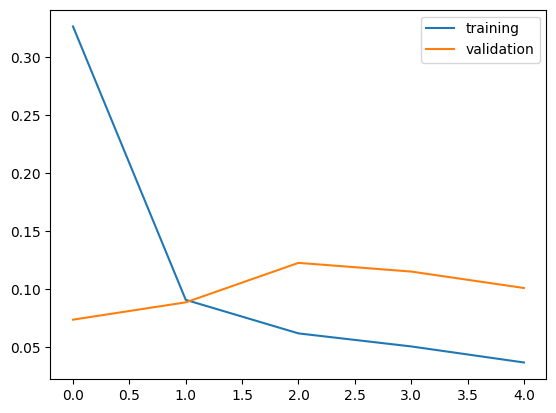

In [18]:
plt.plot(experiment1_history.history['loss'], label = "training")
plt.plot(experiment1_history.history['val_loss'], label = "validation")
plt.legend()

## Experiment 2

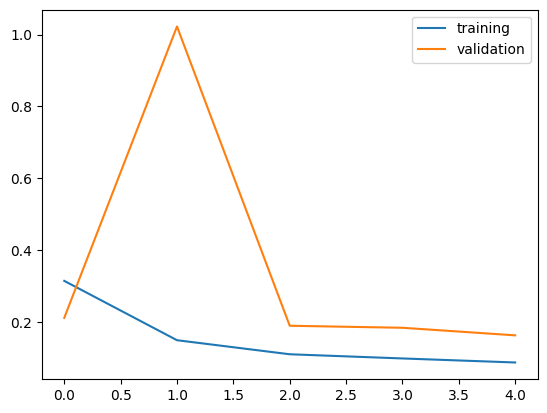

In [19]:
plt.plot(experiment2_history.history['loss'], label = "training")
plt.plot(experiment2_history.history['val_loss'], label = "validation")
plt.legend()

# Conclusion of experiments

The reduction in batch size had 2 distinct effects on the training process. 

Firstly, the overall time taken to complete the training stage increased drastically. The average time taken per epoch for batch size 32 was roughly 523 seconds. A reduction in batch size to 16 resulted in a marginal increase of execution time to roughly 530 seconds per epoch. However with batch size 1 the time taken per epoch increased to about 1150 seconds. This is an increase of about 120% compared to batch size 32.

Secondly, the batch size had an influence on the convergence behavior of the classifiers. Especially the convergence speed of the training processes was affected. What was noticeable from the experiments was that a smaller batch size slows the convergence speed down significantly. This resulted in worse performance for the models which were trained with smaller batch size in this setup.

# Setup test data

In [20]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_data_gen = test_generator.flow_from_directory(directory=test_dir,
                                                   shuffle=False,
                                                   batch_size=batch_size, 
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH))
print(test_data_gen.class_indices)

Found 1500 images belonging to 3 classes.
{'Boot': 0, 'Sandal': 1, 'Shoe': 2}


# Evaluate the model

In [21]:
score = model.evaluate(x=test_data_gen)

47/47 [==============================] - 59s 1s/step - loss: 0.1567 - categorical_accuracy: 0.9587


# Save and load the model

In [22]:
model.save("project.h5")
model = tf.keras.models.load_model("project.h5")

# Run inference

47/47 [==============================] - 62s 1s/step
Accuracy: 0.9586666666666667


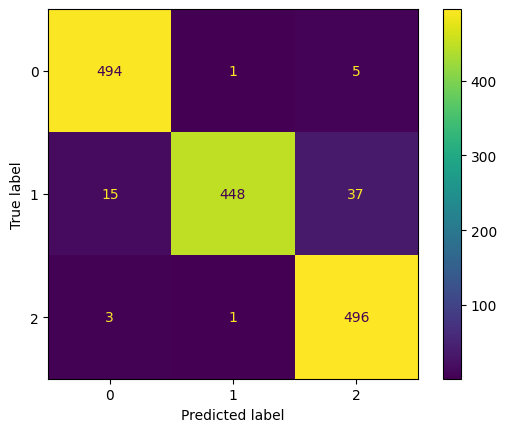

In [23]:
prediction = model.predict(test_data_gen)

predicted_classes = np.argmax(prediction, axis = 1)
actual_classes = test_data_gen.classes

matrix = sklm.ConfusionMatrixDisplay.from_predictions(y_true=actual_classes, y_pred=predicted_classes)
accuracy = sklm.accuracy_score(y_true=actual_classes, y_pred=predicted_classes, normalize=True)

print(f"Accuracy: {accuracy}")